# Denver 2016 Bike Share Multi-Class Classification Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number of checkouts. This section will focus on investigating the use of various classification models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn import linear_model, naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
from sklearn import metrics
import seaborn as sns
from timeit import default_timer as timer
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(402965, 14)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1052163,24-hour Kiosk Only (Denver B-cycle),83,2016-01-01,23,Market Street Station,2016-01-01,23:23:00,19th & Market,2,0.26,4,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Hour       402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Month      402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402965 entries, 0 to 402964
Data columns (total 4 columns):
Checkout_Date       402965 non-null object
Checkout_Month      402965 non-null int64
Checkout_WeekDay    402965 non-null int64
Checkout_Hour       402965 non-null int64
dtypes: int64(3), object(1)
memory usage: 12.3+ MB


In [10]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [16]:
dT.isnull().values.any()

True

In [17]:
nan_rows = dT[dT.isnull().T.any().T]

In [18]:
dT = dT.drop(dT.index[nan_rows.index])

In [19]:
dT.isnull().values.any()

False

In [20]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

In [21]:
dT = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [22]:
dT.shape

(6849, 11)

In [23]:
dT['Number_Of_Checkouts'].max()

252.0

In [24]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849 entries, 8 to 8783
Data columns (total 11 columns):
Checkout_Hour           6849 non-null int64
Apparent_Temperature    6849 non-null float64
Cloud_Cover             6849 non-null float64
Humidity                6849 non-null float64
Temperature             6849 non-null float64
Visibility              6849 non-null float64
Wind_Speed              6849 non-null float64
Checkout_WeekDay        6849 non-null int32
Checkout_Month          6849 non-null int32
Checkout_Date           6849 non-null object
Number_Of_Checkouts     6849 non-null float64
dtypes: float64(7), int32(2), int64(1), object(1)
memory usage: 588.6+ KB


In [25]:
#data = dML.copy(deep=True)

In [26]:
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [27]:
dT = dT[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [28]:
month_dummies = pd.get_dummies(dT.Checkout_Month, prefix='month')

In [29]:
weekday_dummies = pd.get_dummies(dT.Checkout_WeekDay, prefix='weekday')

In [30]:
hour_dummies = pd.get_dummies(dT.Checkout_Hour, prefix='hour')

In [31]:
data = pd.concat([dT, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [32]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [33]:
data['Number_Of_Checkouts'] = data[['Number_Of_Checkouts']].astype('int32')

In [34]:
data['Class_Label'] = data['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 50)) 
                                                else 1 if ((x >= 51)  & (x <= 75)) 
                                                else 2 if ((x >= 76)  & (x <= 100)) 
                                                else 3 if ((x >= 101)  & (x <= 150))
                                                else 4)

In [35]:
data.head()

,Checkout_Month,Checkout_WeekDay,Checkout_Hour,month_1,month_2,month_3,month_4,month_5,month_6,month_7,...,hour_22,hour_23,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts,Class_Label
8,1,4,8,1,0,0,0,0,0,0,...,0,0,6.63,-5.68,0.00,7.61,0.73,10.00,3,0
9,1,4,9,1,0,0,0,0,0,0,...,0,0,13.85,4.28,0.08,6.33,0.64,10.00,8,0
10,1,4,10,1,0,0,0,0,0,0,...,0,0,19.73,9.49,0.16,8.55,0.54,10.00,7,0
11,1,4,11,1,0,0,0,0,0,0,...,0,0,25.91,19.04,0.16,5.93,0.42,10.00,22,0
12,1,4,12,1,0,0,0,0,0,0,...,0,0,29.53,23.17,0.16,6.15,0.37,9.97,13,0


In [36]:
dUT = data.sample(n=10, random_state=123)

In [37]:
del_rows = dUT.index

In [38]:
data.drop(del_rows, axis=0, inplace=True)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 49 columns):
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
month_1                 6839 non-null uint8
month_2                 6839 non-null uint8
month_3                 6839 non-null uint8
month_4                 6839 non-null uint8
month_5                 6839 non-null uint8
month_6                 6839 non-null uint8
month_7                 6839 non-null uint8
month_8                 6839 non-null uint8
month_9                 6839 non-null uint8
month_10                6839 non-null uint8
month_11                6839 non-null uint8
month_12                6839 non-null uint8
weekday_0               6839 non-null uint8
weekday_1               6839 non-null uint8
weekday_2               6839 non-null uint8
weekday_3               6839 non-null uint8
weekday_4               6839 non-null uint8
weekday_5    

In [40]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Class_Label']]

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 48 columns):
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
month_1                 6839 non-null uint8
month_2                 6839 non-null uint8
month_3                 6839 non-null uint8
month_4                 6839 non-null uint8
month_5                 6839 non-null uint8
month_6                 6839 non-null uint8
month_7                 6839 non-null uint8
month_8                 6839 non-null uint8
month_9                 6839 non-null uint8
month_10                6839 non-null uint8
month_11                6839 non-null uint8
month_12                6839 non-null uint8
weekday_0               6839 non-null uint8
weekday_1               6839 non-null uint8
weekday_2               6839 non-null uint8
weekday_3               6839 non-null uint8
weekday_4               6839 non-null uint8
weekday_5    

In [42]:
array = data.values

In [43]:
X = array[:,3:47]
X[0]

array([  1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   6.63,  -5.68,
         0.  ,   7.61,   0.73,  10.  ])

In [44]:
y = array[:,47]
y[0]

0.0

## Feature Correlations

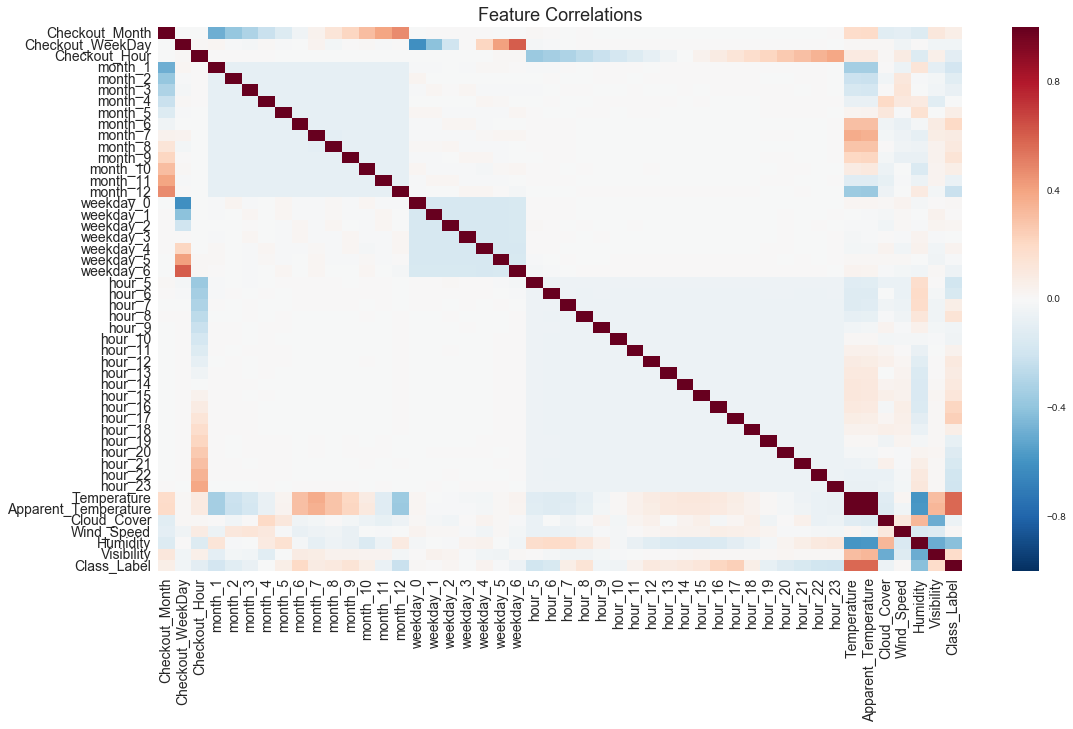

In [45]:
plt.figure(figsize=(18,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [46]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## 2. Modeling - Categorical Feature Set

In [47]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

In [48]:
def get_class_metrics(model, actual, predicted):
    class_metrics = {'Accuracy' : metrics.accuracy_score(actual, predicted),
                         'F1 (macro)' : metrics.f1_score(actual, predicted, average='macro'),
                         'F1 (micro)' : metrics.f1_score(actual, predicted, average='micro'),
                         'Precision (macro)' : metrics.precision_score(actual, predicted,  average='macro'),
                         'Precision (micro)' : metrics.precision_score(actual, predicted,  average='micro'),
                         'Recall (macro)' : metrics.recall_score(actual, predicted,  average='macro'),
                         'Recall (micro)' : metrics.recall_score(actual, predicted,  average='micro')}
    dML_metrics = pd.DataFrame.from_dict(class_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

In [49]:
def perform_classification(model, clfr):   
 
    clfr.fit(X_train, y_train)
    ypred = clfr.predict(X_test)
    got_metrics = get_class_metrics(model, y_test, ypred)
    print(model,'\n')
    print("Accuracy on training set: {:.3f}".format(clfr.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(clfr.score(X_test, y_test)))
    print('\nConfusion Matrix:')
    print(metrics.confusion_matrix(y_test, ypred))
    print('\nClassification Report:')
    print(metrics.classification_report(y_test, ypred))
    return got_metrics

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
def perform_cross_validation(model, clfr):
    shuffle_split = StratifiedShuffleSplit(test_size=.5, train_size=.5, n_splits=5)
    scores = cross_val_score(clfr, X, y, cv=shuffle_split)
    print("Cross-validation scores:\n{}".format(scores))
    print("Cross-validation scores mean: {:.3f}".format(scores.mean()))
    xv_metrics = {'Cross Validation' : scores.mean()}
    dXV_metrics = pd.DataFrame.from_dict(xv_metrics, orient='index')
    dXV_metrics.columns = [model]
    return dXV_metrics

In [51]:
def get_execution_time_metrics(model, et):
    et_metrics = {'Execution Time (sec)' : et}
    dET_metrics = pd.DataFrame.from_dict(et_metrics, orient='index')
    dET_metrics.columns = [model]
    return dET_metrics

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.641

Confusion Matrix:
[[856 127  27   8   1]
 [ 88 132 106  24   1]
 [ 20  77 147  62   6]
 [  7  28  81 135  34]
 [  0   1   4  35  45]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.84      0.86      1019
          1       0.36      0.38      0.37       351
          2       0.40      0.47      0.43       312
          3       0.51      0.47      0.49       285
          4       0.52      0.53      0.52        85

avg / total       0.65      0.64      0.65      2052

Cross-validation scores:
[ 0.62076023  0.63625731  0.64824561  0.65146199  0.63888889]
Cross-validation scores mean: 0.639

Execution Time (sec): 0.337


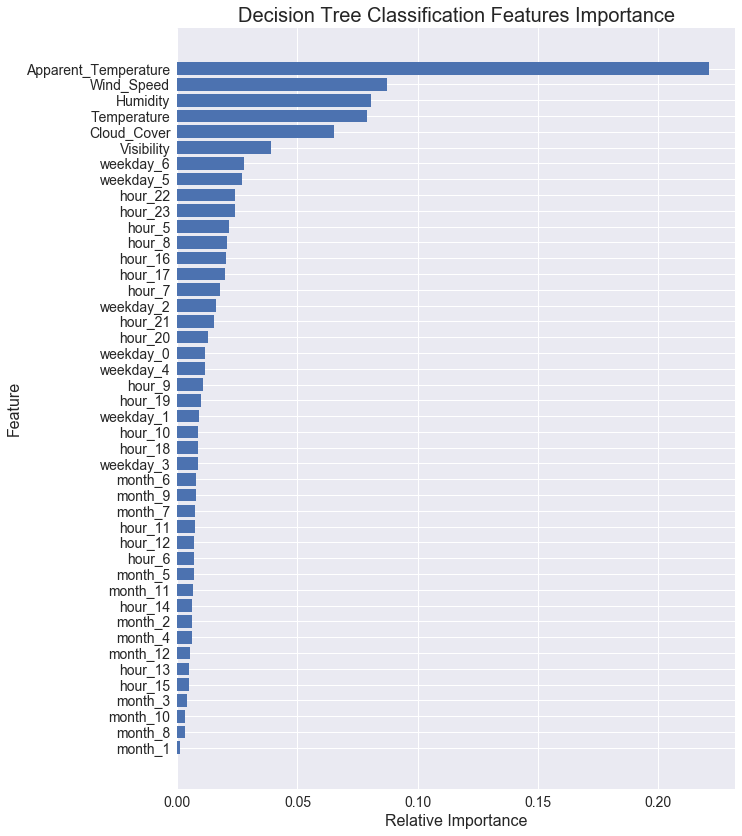

,Decision Tree Classification
Accuracy,0.640838
F1 (macro),0.535669
F1 (micro),0.640838
Precision (macro),0.534911
Precision (micro),0.640838
Recall (macro),0.538071
Recall (micro),0.640838


In [52]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic) Classification

In [53]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

Logistic Classification 

Accuracy on training set: 0.668
Accuracy on test set: 0.662

Confusion Matrix:
[[941  43   5  29   1]
 [165  99  62  24   1]
 [ 50  62 132  64   4]
 [ 31   8  65 168  13]
 [  2   1   4  59  19]]

Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.92      0.85      1019
          1       0.46      0.28      0.35       351
          2       0.49      0.42      0.46       312
          3       0.49      0.59      0.53       285
          4       0.50      0.22      0.31        85

avg / total       0.64      0.66      0.64      2052

Cross-validation scores:
[ 0.64766082  0.65672515  0.65906433  0.65906433  0.6505848 ]
Cross-validation scores mean: 0.655

Execution Time (sec): 15.990


,Logistic Classification
Accuracy,0.662281
F1 (macro),0.500343
F1 (micro),0.662281
Precision (macro),0.547424
Precision (micro),0.662281
Recall (macro),0.488317
Recall (micro),0.662281


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.706

Confusion Matrix:
[[949  57  10   3   0]
 [110 130  96  14   1]
 [ 21  68 170  52   1]
 [ 11  14  78 165  17]
 [  2   0   3  46  34]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.93      0.90      1019
          1       0.48      0.37      0.42       351
          2       0.48      0.54      0.51       312
          3       0.59      0.58      0.58       285
          4       0.64      0.40      0.49        85

avg / total       0.69      0.71      0.70      2052

Cross-validation scores:
[ 0.68596491  0.70467836  0.6997076   0.69561404  0.68947368]
Cross-validation scores mean: 0.695

Execution Time (sec): 4.064


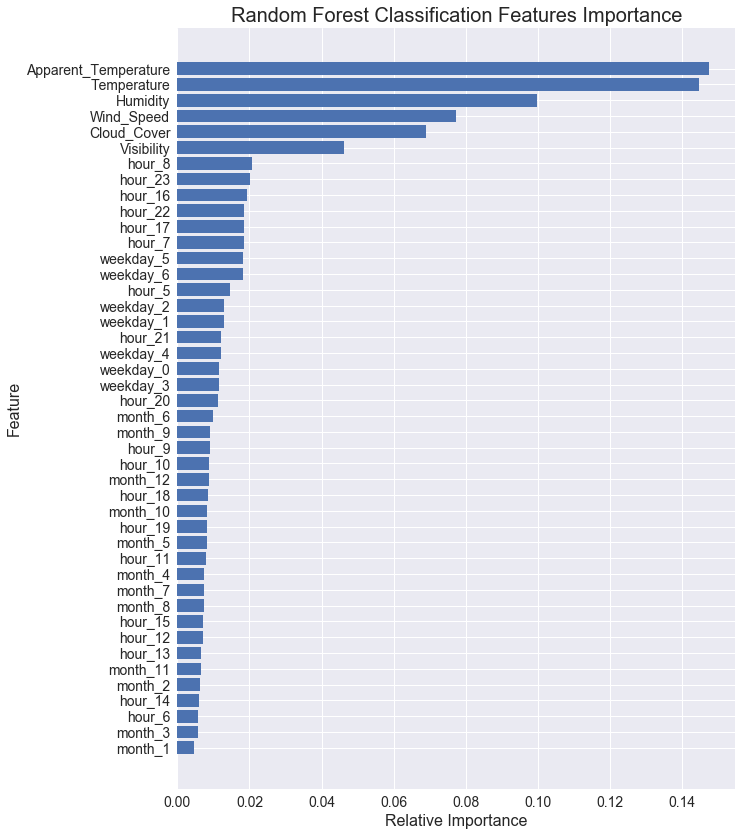

,Random Forest Classification
Accuracy,0.705653
F1 (macro),0.580615
F1 (micro),0.705653
Precision (macro),0.611702
Precision (micro),0.705653
Recall (macro),0.565099
Recall (micro),0.705653


In [54]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.713

Confusion Matrix:
[[947  62   7   3   0]
 [ 99 138 100  13   1]
 [ 14  70 167  58   3]
 [  4  10  78 168  25]
 [  0   1   0  41  43]]

Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.93      0.91      1019
          1       0.49      0.39      0.44       351
          2       0.47      0.54      0.50       312
          3       0.59      0.59      0.59       285
          4       0.60      0.51      0.55        85

avg / total       0.71      0.71      0.71      2052

Cross-validation scores:
[ 0.70994152  0.70906433  0.70964912  0.70497076  0.70877193]
Cross-validation scores mean: 0.708

Execution Time (sec): 3.655


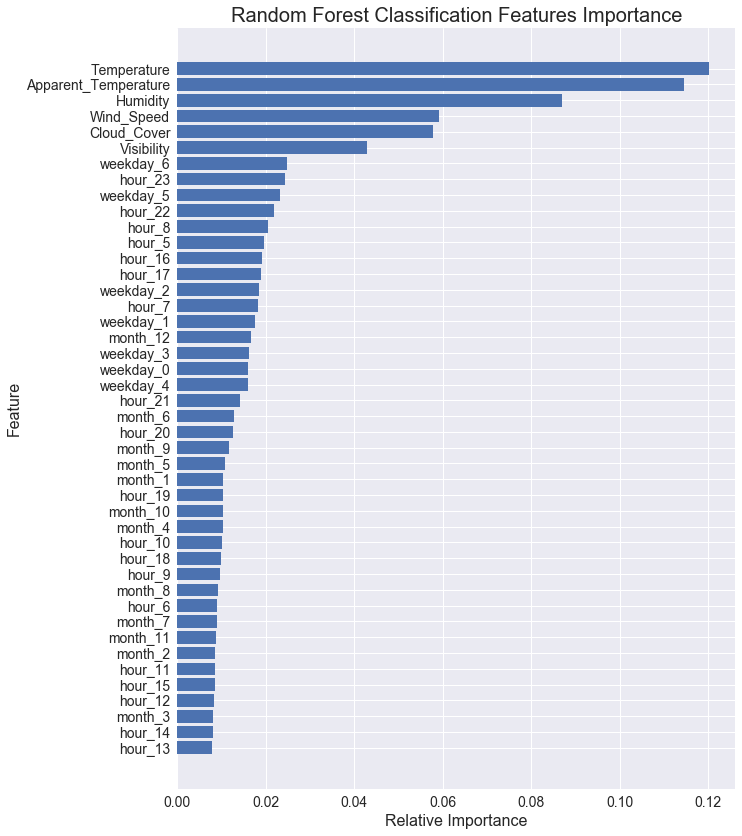

,Extra Trees Classification
Accuracy,0.712963
F1 (macro),0.597661
F1 (micro),0.712963
Precision (macro),0.609287
Precision (micro),0.712963
Recall (macro),0.590623
Recall (micro),0.712963


In [55]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, 'Random Forest Classification')
etc.sort_index()

#### Naive Bayes Classification

In [56]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.357
Accuracy on test set: 0.347

Confusion Matrix:
[[439 399  40  37 104]
 [ 18 108  84  26 115]
 [  2  17  58  33 202]
 [  1   7  11  24 242]
 [  1   0   0   0  84]]

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.43      0.59      1019
          1       0.20      0.31      0.24       351
          2       0.30      0.19      0.23       312
          3       0.20      0.08      0.12       285
          4       0.11      0.99      0.20        85

avg / total       0.59      0.35      0.40      2052

Cross-validation scores:
[ 0.34415205  0.35116959  0.37631579  0.33684211  0.34298246]
Cross-validation scores mean: 0.350

Execution Time (sec): 0.212


,Naive Bayes Classification
Accuracy,0.347466
F1 (macro),0.277657
F1 (micro),0.347466
Precision (macro),0.353727
Precision (micro),0.347466
Recall (macro),0.399370
Recall (micro),0.347466


#### Nearest Neighbors Classification

In [57]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.762
Accuracy on test set: 0.546

Confusion Matrix:
[[917  73  21   8   0]
 [189  80  65  17   0]
 [105 101  68  38   0]
 [ 76  66  89  51   3]
 [ 19  13  21  28   4]]

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.90      0.79      1019
          1       0.24      0.23      0.23       351
          2       0.26      0.22      0.24       312
          3       0.36      0.18      0.24       285
          4       0.57      0.05      0.09        85

avg / total       0.50      0.55      0.50      2052

Cross-validation scores:
[ 0.55730994  0.55292398  0.5502924   0.55467836  0.54649123]
Cross-validation scores mean: 0.552

Execution Time (sec): 0.981


,Nearest Neighbors Classification
Accuracy,0.545809
F1 (macro),0.316936
F1 (micro),0.545809
Precision (macro),0.426109
Precision (micro),0.545809
Recall (macro),0.314355
Recall (micro),0.545809


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.665

Confusion Matrix:
[[908  86  16   7   2]
 [106 137  80  28   0]
 [ 18  79 149  61   5]
 [  8  42  76 134  25]
 [  0   2   4  42  37]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      1019
          1       0.40      0.39      0.39       351
          2       0.46      0.48      0.47       312
          3       0.49      0.47      0.48       285
          4       0.54      0.44      0.48        85

avg / total       0.66      0.67      0.66      2052

Cross-validation scores:
[ 0.65584795  0.66140351  0.6502924   0.65467836  0.63976608]
Cross-validation scores mean: 0.652

Execution Time (sec): 137.870


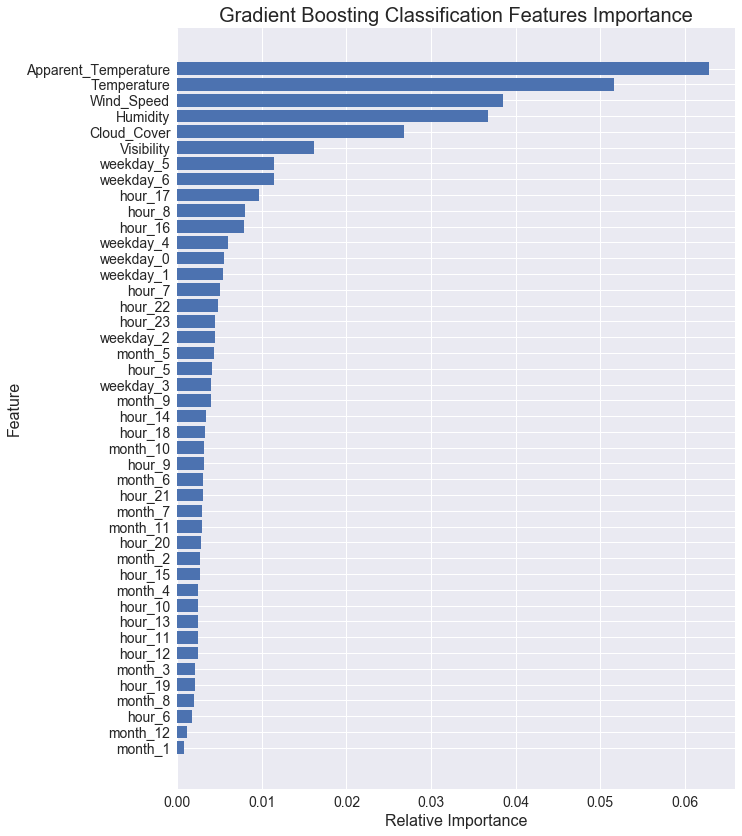

,Gradient Boosting Classification
Accuracy,0.665205
F1 (macro),0.540916
F1 (micro),0.665205
Precision (macro),0.551274
Precision (micro),0.665205
Recall (macro),0.532883
Recall (micro),0.665205


In [58]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [59]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

Multi-Layer Perception Classification 

Accuracy on training set: 0.696
Accuracy on test set: 0.690

Confusion Matrix:
[[960  15  28  15   1]
 [131  28 173  18   1]
 [ 18   5 235  51   3]
 [  6   0  96 177   6]
 [  1   0   3  66  15]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.94      0.90      1019
          1       0.58      0.08      0.14       351
          2       0.44      0.75      0.55       312
          3       0.54      0.62      0.58       285
          4       0.58      0.18      0.27        85

avg / total       0.69      0.69      0.65      2052

Cross-validation scores:
[ 0.66842105  0.67836257  0.67602339  0.65204678  0.65175439]
Cross-validation scores mean: 0.665

Execution Time (sec): 9.565


,Multi-Layer Perception Classification
Accuracy,0.689571
F1 (macro),0.488650
F1 (micro),0.689571
Precision (macro),0.600202
Precision (micro),0.689571
Recall (macro),0.514520
Recall (micro),0.689571


## Classification Summary with Categorical Feature Set

In [60]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [61]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [62]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [63]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Categorical Features\n")
final_metrics

Classification Summary with Categorical Features



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.662281,0.640838,0.705653,0.712963,0.347466,0.545809,0.665205,0.689571
F1 (macro),0.500343,0.535669,0.580615,0.597661,0.277657,0.316936,0.540916,0.488650
F1 (micro),0.662281,0.640838,0.705653,0.712963,0.347466,0.545809,0.665205,0.689571
Precision (macro),0.547424,0.534911,0.611702,0.609287,0.353727,0.426109,0.551274,0.600202
Precision (micro),0.662281,0.640838,0.705653,0.712963,0.347466,0.545809,0.665205,0.689571
Recall (macro),0.488317,0.538071,0.565099,0.590623,0.399370,0.314355,0.532883,0.514520
Recall (micro),0.662281,0.640838,0.705653,0.712963,0.347466,0.545809,0.665205,0.689571
Cross Validation,0.654620,0.639123,0.695088,0.708480,0.350292,0.552339,0.652398,0.665322
Execution Time (sec),15.989999,0.337216,4.064112,3.654782,0.211667,0.980936,137.870316,9.564595


The multi-layer perceptron model attained the highest accuracy in classifying the four classes. The Naïve Bayes model performed the poorest.

## 3. Modeling - Numerical Feature Set

In [64]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 
           'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Class_Label']]

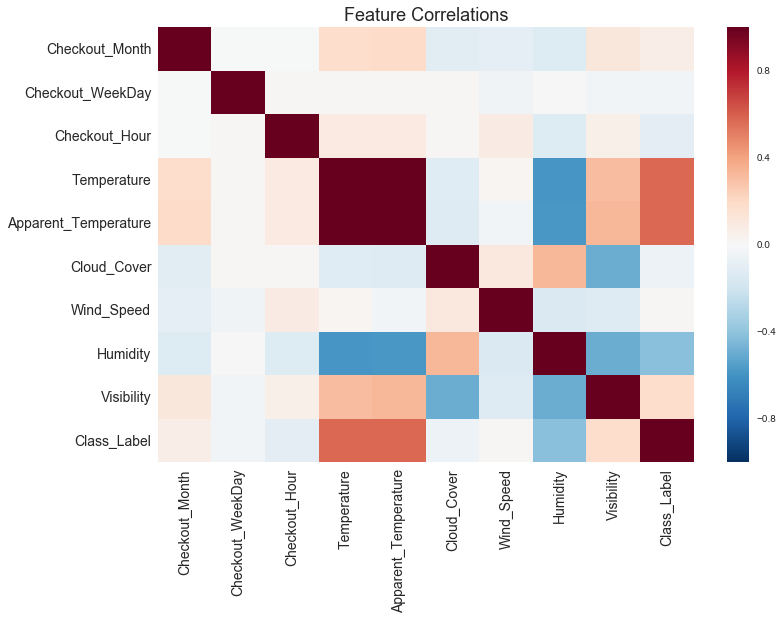

In [65]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6839 entries, 8 to 8783
Data columns (total 10 columns):
Checkout_Month          6839 non-null int32
Checkout_WeekDay        6839 non-null int32
Checkout_Hour           6839 non-null int64
Temperature             6839 non-null float64
Apparent_Temperature    6839 non-null float64
Cloud_Cover             6839 non-null float64
Wind_Speed              6839 non-null float64
Humidity                6839 non-null float64
Visibility              6839 non-null float64
Class_Label             6839 non-null int64
dtypes: float64(6), int32(2), int64(2)
memory usage: 534.3 KB


In [67]:
array = data.values
X = array[:,0:8]
y = array[:,8]

In [68]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Class_Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [69]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

#### Decision Tree Classification

Decision Tree Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.654

Confusion Matrix:
[[874 113  26   5   1]
 [ 83 132 104  30   2]
 [ 24  71 145  67   5]
 [  2  28  65 153  37]
 [  0   0   1  45  39]]

Classification Report:
             precision    recall  f1-score   support

          0       0.89      0.86      0.87      1019
          1       0.38      0.38      0.38       351
          2       0.43      0.46      0.44       312
          3       0.51      0.54      0.52       285
          4       0.46      0.46      0.46        85

avg / total       0.66      0.65      0.66      2052

Cross-validation scores:
[ 0.64912281  0.65643275  0.65847953  0.64444444  0.6374269 ]
Cross-validation scores mean: 0.649

Execution Time (sec): 0.218


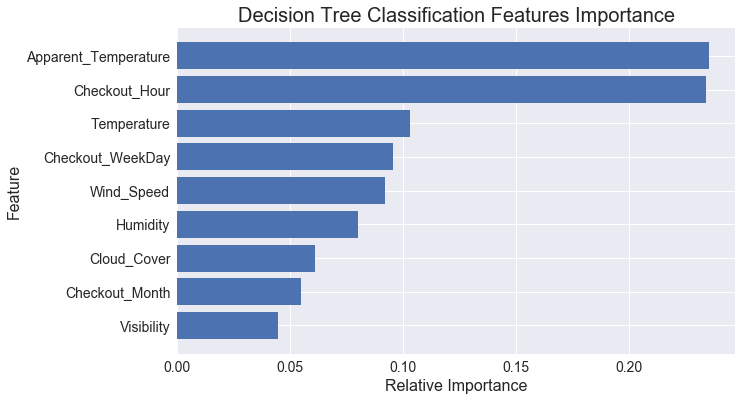

,Decision Tree Classification
Accuracy,0.654483
F1 (macro),0.536341
F1 (micro),0.654483
Precision (macro),0.534468
Precision (micro),0.654483
Recall (macro),0.538836
Recall (micro),0.654483


In [70]:
# Decision Tree Classifier
class_model = 'Decision Tree Classification'
start = timer()
clf = DecisionTreeClassifier(random_state=0)
dtc = perform_classification(class_model, clf)
dtc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format(et))
dtc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
dtc.sort_index()

#### Linear (Logistic Regression) Classification

In [71]:
# logistic regression
class_model = 'Logistic Classification'
start = timer()
#clf = linear_model.LogisticRegression(random_state=0)
clf = linear_model.LogisticRegression(C=1.0, solver='lbfgs', random_state=0, multi_class='ovr', n_jobs=-1)
lin_reg = perform_classification(class_model, clf)
lin_reg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
lin_reg_et = get_execution_time_metrics(class_model, et)
lin_reg.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic Classification 

Accuracy on training set: 0.575
Accuracy on test set: 0.572

Confusion Matrix:
[[955  22  16  26   0]
 [196  38  63  54   0]
 [112  42  83  75   0]
 [104  25  59  97   0]
 [ 14   6  26  39   0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.69      0.94      0.80      1019
          1       0.29      0.11      0.16       351
          2       0.34      0.27      0.30       312
          3       0.33      0.34      0.34       285
          4       0.00      0.00      0.00        85

avg / total       0.49      0.57      0.51      2052

Cross-validation scores:
[ 0.56988304  0.5751462   0.56754386  0.57222222  0.58245614]
Cross-validation scores mean: 0.573

Execution Time (sec): 14.258


,Logistic Classification
Accuracy,0.571637
F1 (macro),0.317325
F1 (micro),0.571637
Precision (macro),0.329322
Precision (micro),0.571637
Recall (macro),0.330366
Recall (micro),0.571637


#### Random Forest Classification

Random Forest Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.702

Confusion Matrix:
[[946  60  11   2   0]
 [103 136  96  16   0]
 [ 15  77 161  58   1]
 [  7  23  70 171  14]
 [  1   0   3  54  27]]

Classification Report:
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      1019
          1       0.46      0.39      0.42       351
          2       0.47      0.52      0.49       312
          3       0.57      0.60      0.58       285
          4       0.64      0.32      0.43        85

avg / total       0.69      0.70      0.69      2052

Cross-validation scores:
[ 0.69473684  0.69356725  0.69093567  0.6874269   0.69181287]
Cross-validation scores mean: 0.692

Execution Time (sec): 4.203


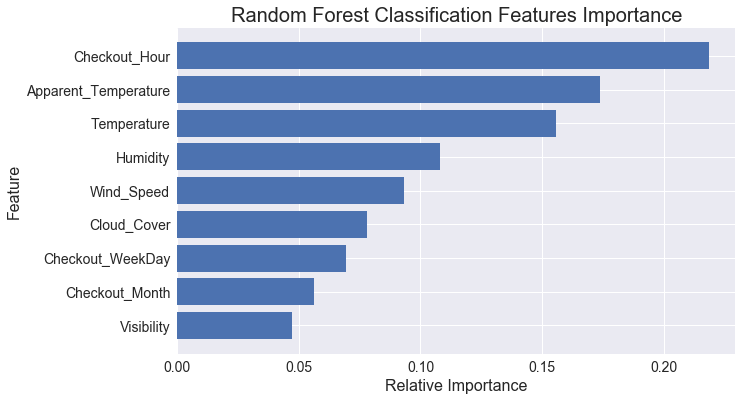

,Random Forest Classification
Accuracy,0.702242
F1 (macro),0.565431
F1 (micro),0.702242
Precision (macro),0.605005
Precision (micro),0.702242
Recall (macro),0.549900
Recall (micro),0.702242


In [72]:
# Random Forest Classifier
class_model = 'Random Forest Classification'
start = timer() 
clf = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc = perform_classification(class_model, clf)
rfc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
rfc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
rfc.sort_index()

#### Extra Trees Classification

Extra Trees Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.701

Confusion Matrix:
[[949  61   7   2   0]
 [112 131  87  21   0]
 [ 23  68 156  62   3]
 [  9  19  67 167  23]
 [  1   0   2  47  35]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.93      0.90      1019
          1       0.47      0.37      0.42       351
          2       0.49      0.50      0.49       312
          3       0.56      0.59      0.57       285
          4       0.57      0.41      0.48        85

avg / total       0.69      0.70      0.69      2052

Cross-validation scores:
[ 0.69035088  0.69064327  0.69561404  0.69181287  0.68596491]
Cross-validation scores mean: 0.691

Execution Time (sec): 3.454


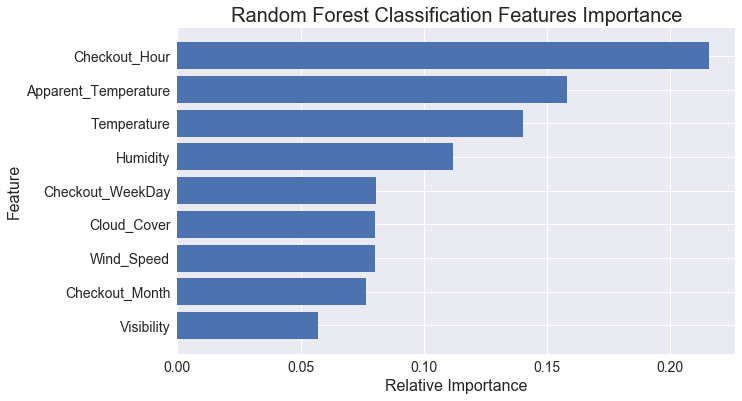

,Extra Trees Classification
Accuracy,0.700780
F1 (macro),0.571989
F1 (micro),0.700780
Precision (macro),0.591664
Precision (micro),0.700780
Recall (macro),0.560451
Recall (micro),0.700780


In [73]:
# Extra Trees Classifier
class_model = 'Extra Trees Classification'
start = timer() 
clf = ExtraTreesClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
etc = perform_classification(class_model, clf)
etc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
etc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, 'Random Forest Classification')
etc.sort_index()

#### Naive Bayes Classification

In [74]:
# Naive Bayes Classifier
class_model = 'Naive Bayes Classification'
start = timer()
clf = naive_bayes.GaussianNB()
nbg = perform_classification(class_model, clf)
nbg_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
nbg_et = get_execution_time_metrics(class_model, et)
nbg.sort_index()

Naive Bayes Classification 

Accuracy on training set: 0.489
Accuracy on test set: 0.462

Confusion Matrix:
[[690 171   0 150   8]
 [ 81  60   8 174  28]
 [ 44  36   7 193  32]
 [ 24  38   5 178  40]
 [  2   2   2  65  14]]

Classification Report:
             precision    recall  f1-score   support

          0       0.82      0.68      0.74      1019
          1       0.20      0.17      0.18       351
          2       0.32      0.02      0.04       312
          3       0.23      0.62      0.34       285
          4       0.11      0.16      0.14        85

avg / total       0.53      0.46      0.46      2052

Cross-validation scores:
[ 0.47719298  0.46959064  0.46432749  0.46023392  0.48245614]
Cross-validation scores mean: 0.471

Execution Time (sec): 0.129


,Naive Bayes Classification
Accuracy,0.462476
F1 (macro),0.288432
F1 (micro),0.462476
Precision (macro),0.336608
Precision (micro),0.462476
Recall (macro),0.331956
Recall (micro),0.462476


#### Nearest Neighbors Classification

In [75]:
# Nearest Neighbors Classifier
class_model = 'Nearest Neighbors Classification'
start = timer()
clf = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
knn = perform_classification(class_model, clf)
knn_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
knn_et = get_execution_time_metrics(class_model, et)
knn.sort_index()

Nearest Neighbors Classification 

Accuracy on training set: 0.799
Accuracy on test set: 0.608

Confusion Matrix:
[[931  70  11   7   0]
 [147 124  70  10   0]
 [ 53 112 104  39   4]
 [ 32  67  98  83   5]
 [  3   6  23  47   6]]

Classification Report:
             precision    recall  f1-score   support

          0       0.80      0.91      0.85      1019
          1       0.33      0.35      0.34       351
          2       0.34      0.33      0.34       312
          3       0.45      0.29      0.35       285
          4       0.40      0.07      0.12        85

avg / total       0.58      0.61      0.59      2052

Cross-validation scores:
[ 0.60584795  0.60730994  0.60263158  0.60526316  0.60526316]
Cross-validation scores mean: 0.605

Execution Time (sec): 0.957


,Nearest Neighbors Classification
Accuracy,0.608187
F1 (macro),0.400182
F1 (micro),0.608187
Precision (macro),0.462348
Precision (micro),0.608187
Recall (macro),0.392413
Recall (micro),0.608187


#### Gradient Boosting Classification

Gradient Boosting Classification 

Accuracy on training set: 1.000
Accuracy on test set: 0.671

Confusion Matrix:
[[920  81  15   3   0]
 [117 131  80  22   1]
 [ 28  85 139  58   2]
 [  9  34  71 147  24]
 [  1   4   2  39  39]]

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.90      0.88      1019
          1       0.39      0.37      0.38       351
          2       0.45      0.45      0.45       312
          3       0.55      0.52      0.53       285
          4       0.59      0.46      0.52        85

avg / total       0.66      0.67      0.67      2052

Cross-validation scores:
[ 0.66140351  0.66023392  0.67777778  0.64824561  0.65555556]
Cross-validation scores mean: 0.661

Execution Time (sec): 76.372


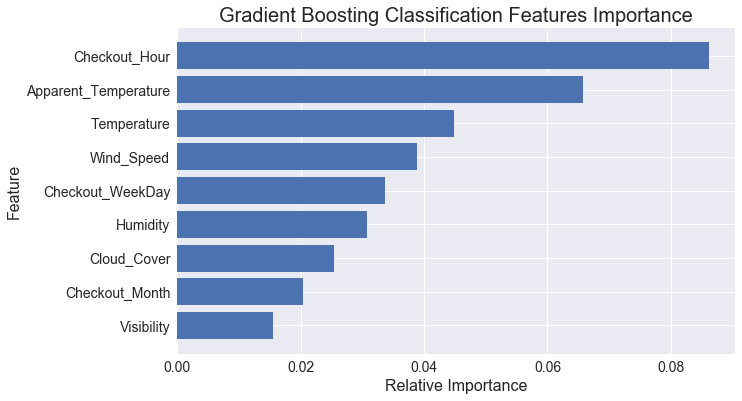

,Gradient Boosting Classification
Accuracy,0.670565
F1 (macro),0.551396
F1 (micro),0.670565
Precision (macro),0.567401
Precision (micro),0.670565
Recall (macro),0.539238
Recall (micro),0.670565


In [76]:
# Gradient Boosting Classifier
class_model = 'Gradient Boosting Classification'
#clf = GradientBoostingClassifier()
start = timer()
clf = GradientBoostingClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0)
gbc = perform_classification(class_model, clf)
gbc_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
gbc_et = get_execution_time_metrics(class_model, et)
plot_feature_importances(clf, class_model)
gbc.sort_index()

#### Multi-layer Perceptron Classification

In [77]:
# Multi-Layer Perceptron Classification
class_model = 'Multi-Layer Perception Classification'
start = timer()
clf = MLPClassifier(random_state=0)
mlp = perform_classification(class_model, clf)
mlp_xv = perform_cross_validation(class_model, clf)
end = timer()
et = end - start
print("\nExecution Time (sec): {:.3f}".format((end - start)))
mlp_et = get_execution_time_metrics(class_model, et)
mlp.sort_index()

C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Multi-Layer Perception Classification 

Accuracy on training set: 0.593
Accuracy on test set: 0.585

Confusion Matrix:
[[954  60   0   5   0]
 [164 131   7  49   0]
 [ 71 160   7  74   0]
 [ 71 103   2 109   0]
 [ 10  28   0  47   0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.94      0.83      1019
          1       0.27      0.37      0.31       351
          2       0.44      0.02      0.04       312
          3       0.38      0.38      0.38       285
          4       0.00      0.00      0.00        85

avg / total       0.54      0.59      0.53      2052

Cross-validation scores:
[ 0.57923977  0.58333333  0.56695906  0.59269006  0.57982456]
Cross-validation scores mean: 0.580

Execution Time (sec): 4.314


,Multi-Layer Perception Classification
Accuracy,0.585283
F1 (macro),0.314778
F1 (micro),0.585283
Precision (macro),0.368854
Precision (micro),0.585283
Recall (macro),0.342865
Recall (micro),0.585283


## Classification Summary with Numerical Feature Set

In [78]:
class_metrics = pd.concat([lin_reg, dtc, rfc, etc, nbg, knn, gbc, mlp] , axis=1)

In [79]:
xv_metrics = pd.concat([lin_reg_xv, dtc_xv, rfc_xv, etc_xv, nbg_xv, knn_xv, gbc_xv, mlp_xv], axis = 1)

In [80]:
et_metrics = pd.concat([lin_reg_et, dtc_et, rfc_et, etc_et, nbg_et, knn_et, gbc_et, mlp_et], axis = 1)

In [81]:
final_metrics = pd.concat([class_metrics, xv_metrics, et_metrics])
print("Classification Summary with Numerical Feature Set\n")
final_metrics

Classification Summary with Numerical Feature Set



,Logistic Classification,Decision Tree Classification,Random Forest Classification,Extra Trees Classification,Naive Bayes Classification,Nearest Neighbors Classification,Gradient Boosting Classification,Multi-Layer Perception Classification
Accuracy,0.571637,0.654483,0.702242,0.700780,0.462476,0.608187,0.670565,0.585283
F1 (macro),0.317325,0.536341,0.565431,0.571989,0.288432,0.400182,0.551396,0.314778
F1 (micro),0.571637,0.654483,0.702242,0.700780,0.462476,0.608187,0.670565,0.585283
Precision (macro),0.329322,0.534468,0.605005,0.591664,0.336608,0.462348,0.567401,0.368854
Precision (micro),0.571637,0.654483,0.702242,0.700780,0.462476,0.608187,0.670565,0.585283
Recall (macro),0.330366,0.538836,0.549900,0.560451,0.331956,0.392413,0.539238,0.342865
Recall (micro),0.571637,0.654483,0.702242,0.700780,0.462476,0.608187,0.670565,0.585283
Cross Validation,0.573450,0.649181,0.691696,0.690877,0.470760,0.605263,0.660643,0.580409
Execution Time (sec),14.257541,0.217554,4.202843,3.453612,0.128580,0.957223,76.372264,4.313864


## Test Random Forest Classifier on Unseen Samples

In [82]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
dUT['Class_Label'] = dUT['Number_Of_Checkouts'].map(lambda x: 0 if ((x >= 1) & (x <= 50)) 
                                                else 1 if ((x >= 51)  & (x <= 75)) 
                                                else 2 if ((x >= 76)  & (x <= 100)) 
                                                else 3 if ((x >= 101)  & (x <= 150))
                                                else 4)
pred_X = dUT[features]
act_y = dUT['Class_Label']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,10].astype(int)

rfc = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=None, random_state=0, n_jobs=-1)
rfc.fit(X, y)
pred = rfc.predict(pred_X_array)
print('predicted =', pred)
print('actual =   ', act_y_array)

predicted = [3 0 0 3 1 0 0 0 0 0]
actual =    [2 0 1 3 2 0 0 2 1 0]


## 4. Summary

The Gradient Boosting Classifier achieved the highest accuracy and the Naïve Bayes the lowest. While the Multi-Layer Perceptron model had better accuracy than the Gradient Boosting with the categorical feature set it did not fare as well with the numerical feature set.